In [3]:
!pip3 install influxdb-client
!pip3 install tensorflow
!pip3 install pandas
!pip3 install numpy
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install scalecast
!pip3 install seaborn
!pip3 install keras
!pip3 install darts
# brew install libomp

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.4/819.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.warnings import MissingPivotFunction
from sklearn.model_selection import train_test_split
from scalecast.Forecaster import Forecaster
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import EarlyStopping
from darts import TimeSeries
import seaborn as sns
import time
import warnings
sns.set(rc={'figure.figsize':(25,8)})

In [2]:
# Reading data from DB

# InfluxDB credentials and details
url = "http://kammeyer.uk:8086"
token = "9V1NYZbTXZkbf9H0Szf8Gl-dOaqrl97TmdC9gwNhxkRCgAcHR7jGSxnPtwHq2vBL-UOd607yPlROxlJAhRAwqw=="
org = "messme"

# Initialize InfluxDB Client
client = InfluxDBClient(url=url, token=token, org=org)

# Define the query for the 'energy' bucket
query = """
from(bucket: "energy")
  |> range(start: -2y)
  |> filter(fn: (r) => r._measurement == "energy_production")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""


# Fetch data into a DataFrame
start = time.time()
df = client.query_api().query_data_frame(query=query)
end = time.time()
print("Time taken to read the data is : ", end-start)
df.head()

Time taken to read the data is :  10.343713521957397


,result,table,_start,_stop,_time,_measurement,region,Biomasse,Braunkohle,Erdgas,Kernenergie,Photovoltaik,Pumpspeicher,Sonstige Erneuerbare,Sonstige Konventionelle,Steinkohle,Wasserkraft,Wind Offshore,Wind Onshore
0,_result,0,2022-02-02 21:28:56.549679+00:00,2024-02-03 09:28:56.549679+00:00,2022-02-02 21:30:00+00:00,energy_production,DE,1171.00,2994.00,2116.25,1021.00,0.0,68.50,47.50,378.75,2587.00,259.25,788.75,3302.75
1,_result,0,2022-02-02 21:28:56.549679+00:00,2024-02-03 09:28:56.549679+00:00,2022-02-02 21:45:00+00:00,energy_production,DE,1168.75,2988.75,2058.25,1021.00,0.0,15.75,47.50,376.00,2592.25,259.75,753.75,3357.75
2,_result,0,2022-02-02 21:28:56.549679+00:00,2024-02-03 09:28:56.549679+00:00,2022-02-02 22:00:00+00:00,energy_production,DE,1161.25,3035.25,1918.75,1021.00,0.0,74.25,47.50,377.75,2599.25,273.25,735.75,3406.50
3,_result,0,2022-02-02 21:28:56.549679+00:00,2024-02-03 09:28:56.549679+00:00,2022-02-02 22:15:00+00:00,energy_production,DE,1159.50,3054.00,1860.00,1018.50,0.0,2.25,47.25,377.25,2600.75,262.00,732.75,3424.00
4,_result,0,2022-02-02 21:28:56.549679+00:00,2024-02-03 09:28:56.549679+00:00,2022-02-02 22:30:00+00:00,energy_production,DE,1157.00,3062.75,1799.00,1019.25,0.0,0.50,47.50,378.00,2537.00,260.75,715.50,3484.00


In [3]:
# drop extra columns
columns_to_drop = ['result', '_start', '_stop', '_measurement', 'region']
df = df.drop(columns=columns_to_drop, inplace=False)

# Set index
df['_time'] = pd.to_datetime(df['_time'])
df = df.set_index('_time')

# Sort the DataFrame by index
df = df.sort_index()

df_Wind_Offshore = df[["Wind Offshore"]]

print(df_Wind_Offshore)
nan_count = df_Wind_Offshore.isna().sum()
print("df_Wind_Offshore shape is : ", df_Wind_Offshore.shape)
print("Number of NaN values in 'Wind Offshore' column:", nan_count)
df_Wind_Offshore = df_Wind_Offshore.ffill() # forward filling missing values
print("df_Wind_Offshore_cleaned shape is : ", df_Wind_Offshore.shape)

                           Wind Offshore
_time                                   
2022-02-02 21:30:00+00:00         788.75
2022-02-02 21:45:00+00:00         753.75
2022-02-02 22:00:00+00:00         735.75
2022-02-02 22:15:00+00:00         732.75
2022-02-02 22:30:00+00:00         715.50
...                                  ...
2024-02-03 07:15:00+00:00        1143.50
2024-02-03 07:30:00+00:00        1139.50
2024-02-03 07:45:00+00:00        1129.50
2024-02-03 08:00:00+00:00        1037.50
2024-02-03 08:15:00+00:00        1038.75

[70092 rows x 1 columns]
df_Wind_Offshore shape is :  (70092, 1)
Number of NaN values in 'Wind Offshore' column: Wind Offshore    31
dtype: int64
df_Wind_Offshore_cleaned shape is :  (70092, 1)


In [5]:
df_Wind_Offshore.head()

,Wind Offshore
_time,
2022-02-02 21:30:00+00:00,788.75
2022-02-02 21:45:00+00:00,753.75
2022-02-02 22:00:00+00:00,735.75
2022-02-02 22:15:00+00:00,732.75
2022-02-02 22:30:00+00:00,715.50


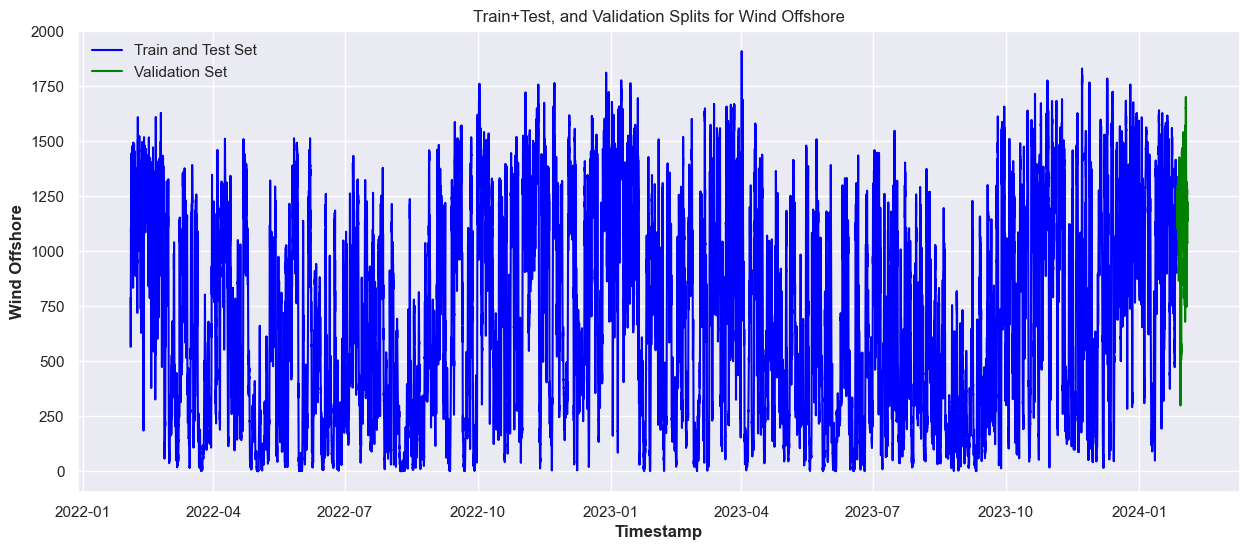

In [6]:
# Train, Test and Validation Splits
train_test_data = df_Wind_Offshore[:-672].copy()

# Split data into train, test, and validation sets
validation_data = df_Wind_Offshore[-672:]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(train_test_data.index, train_test_data['Wind Offshore'], label='Train and Test Set', color='blue')
plt.plot(validation_data.index, validation_data['Wind Offshore'], label='Validation Set', color='green')

plt.title('Train+Test, and Validation Splits for Wind Offshore')
plt.xlabel('Timestamp')
plt.ylabel('Wind Offshore')
plt.legend()
plt.show()

In [8]:
f = Forecaster(y=train_test_data['Wind Offshore'], current_dates=train_test_data.index, freq='15T')

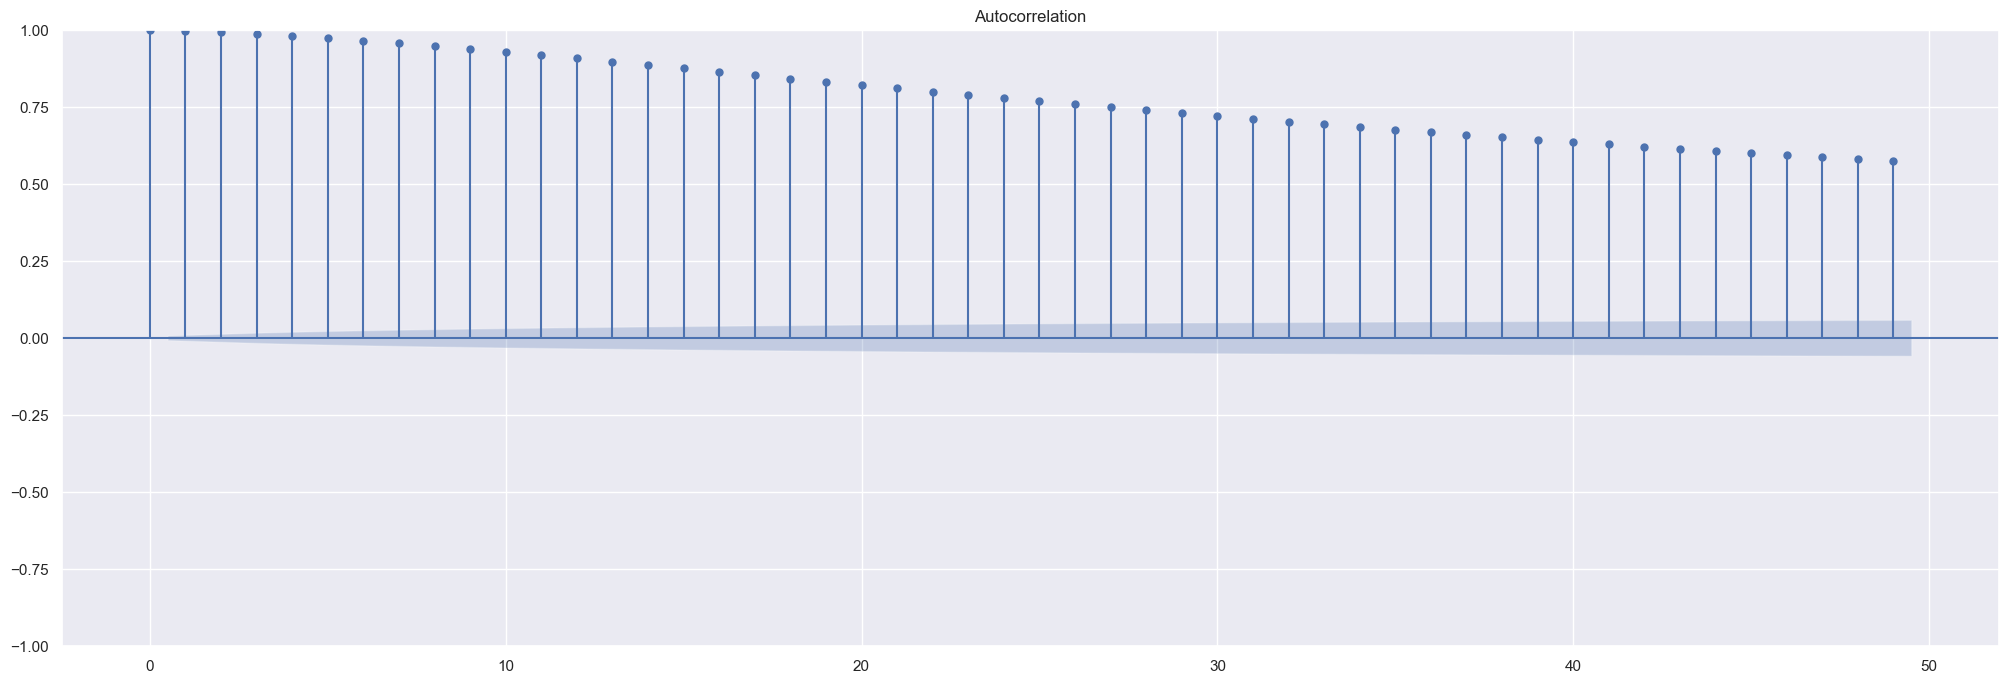

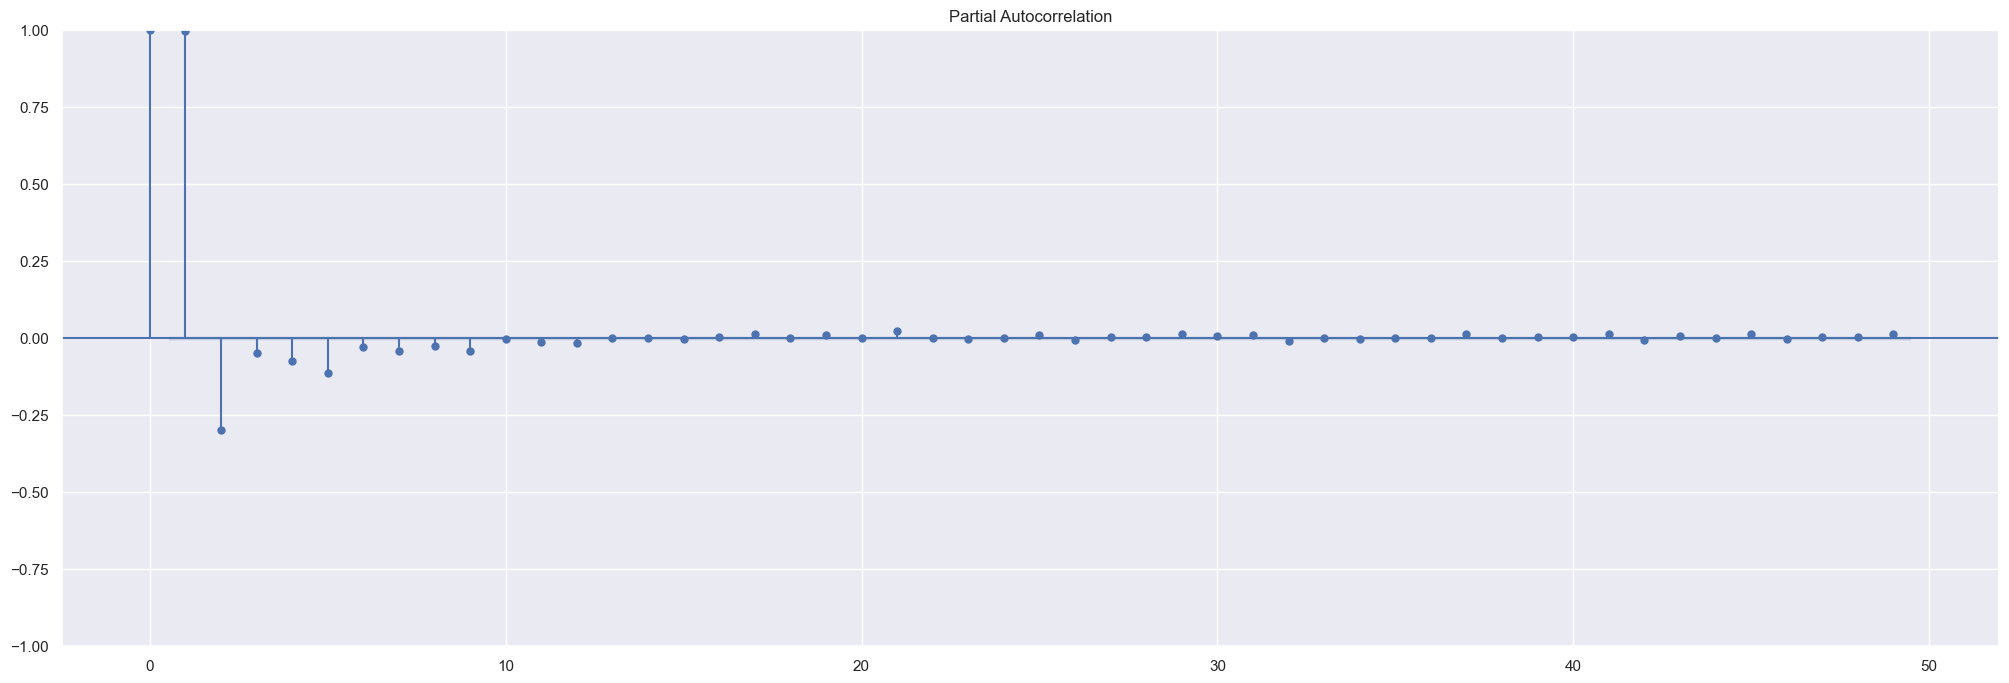

In [9]:
f.plot_acf()
f.plot_pacf()
plt.show()

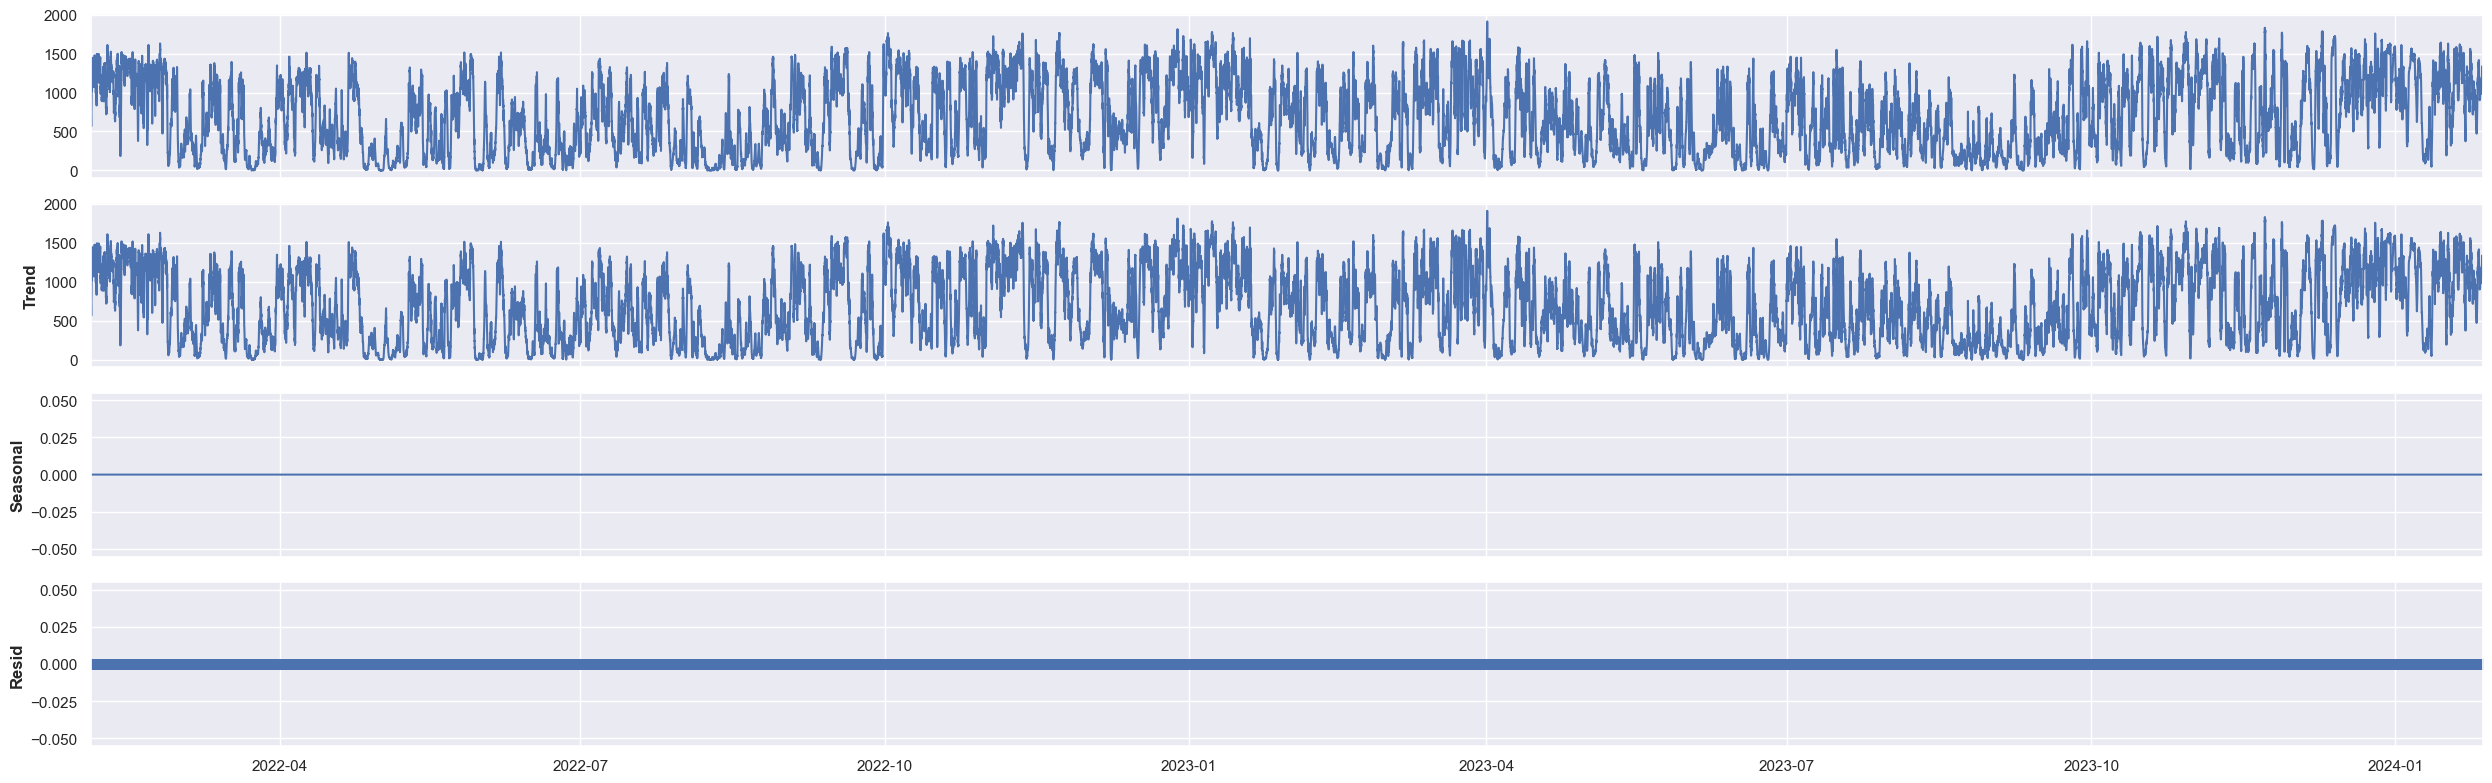

In [10]:
# Perform seasonal decomposition
result = seasonal_decompose(train_test_data, model='additive', extrapolate_trend='freq', period=1)

# Plot the decomposed components
result.plot()
plt.show()

In [11]:
is_stationary = f.adf_test(full_res=False)
print(is_stationary)

True


In [12]:
f.set_test_length(0.10)

In [13]:
f.eval_cis()

In [14]:
f.add_time_trend()

In [15]:
f.add_seasonal_regressors('month','quarter','week','dayofyear',raw=False,sincos=True)
f.add_seasonal_regressors('dayofweek','is_leap_year','week',raw=False,dummy=True,drop_first=True)
f.add_seasonal_regressors('year')

In [16]:
f.generate_future_dates(1344)
f.set_estimator('lstm')

In [19]:
f.manual_forecast(call_me='lstm_best',
                  lags=36,
                  batch_size=32,
                  epochs=25,
                  validation_split=0.1,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=8),
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...layers\lstm_2
......vars
...layers\lstm_2\cell
......vars
.........0
.........1
.........2
...layers\lstm_3
......vars
...layers\lstm_3\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........25
.........26
.........27
.........28
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified    

KeyboardInterrupt: 

Mean Absolute Error (MAE) prediction vs validation set : 349.4335087113792


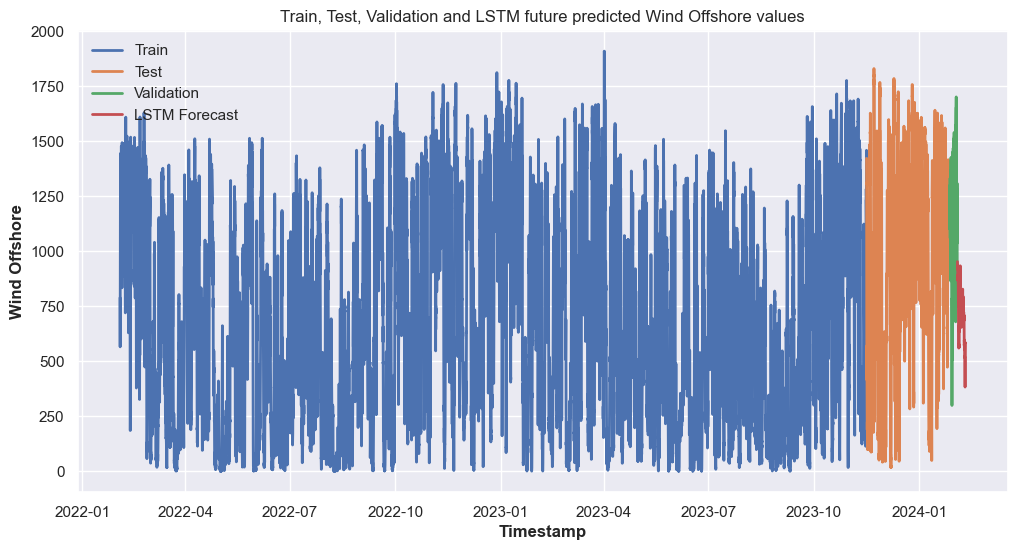

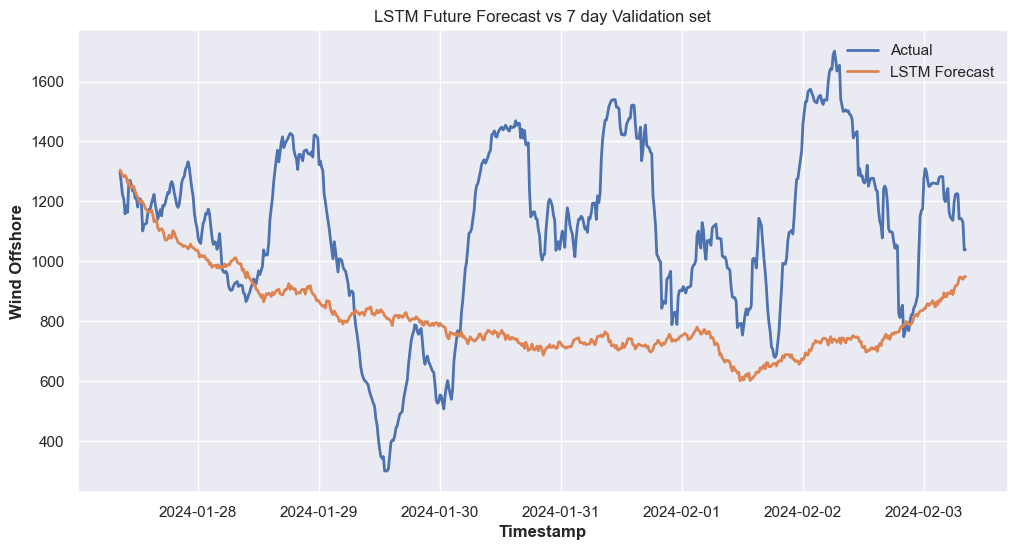

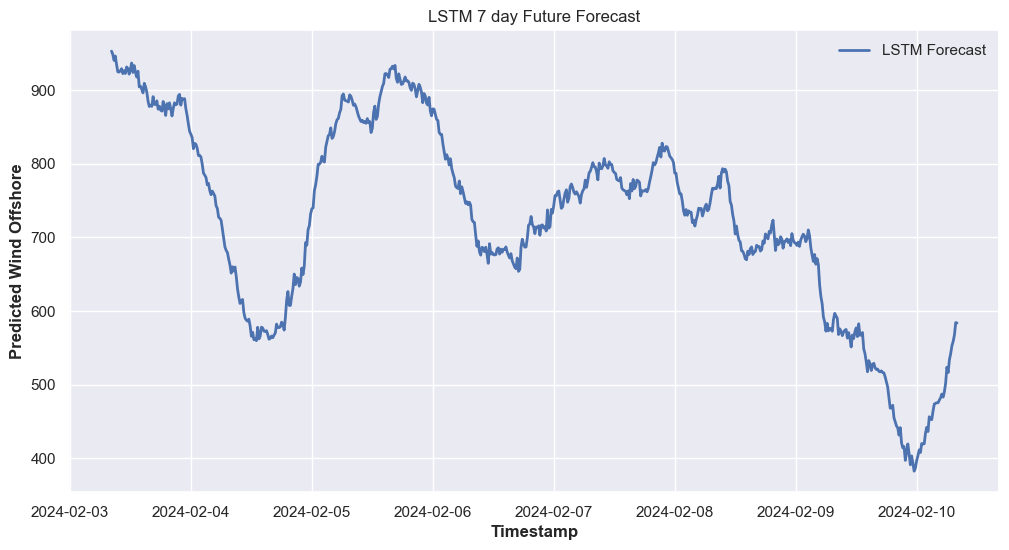

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Get future forecast values and index
lstm_default_forecasted_df = f.export('lvl_fcsts')
last_timestamp = validation_data.index[-1]
new_index = pd.date_range(start=last_timestamp, periods=672, freq='15T')
existing_index_series = pd.Series(validation_data.index)
new_index_series = pd.Series(new_index)
concatenated_series = pd.concat([existing_index_series, new_index_series])
lstm_default_forecasted_df.index = concatenated_series

# Calculate MAE
mae = mean_absolute_error(validation_data["Wind Offshore"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
mape = mean_absolute_percentage_error(validation_data["Wind Offshore"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
rmse = root_mean_squared_error(validation_data["Wind Offshore"].values, lstm_default_forecasted_df["lstm_best"].values[:672])

# Add more metrics here
print(f'Mean Absolute Error (MAE) prediction vs validation set : {mae}')
print(f'Mean Absolute Percentage Error (MAPE) prediction vs validation set : {mape*100:.2f}%')
print(f'Root Mean Squared Error (RMSE) prediction vs validation set : {rmse}')

# Split train_test_data into separate train and test sets and train_index and test_index
train_index, test_index = train_test_split(train_test_data.index, test_size=0.1, shuffle=False, random_state=42)
train,test = train_test_split(train_test_data["Wind Offshore"], test_size=0.1, shuffle=False, random_state=42)


# Plotting train+test, validation and future predictions together
plt.figure(figsize=(12, 6))
plt.plot(train_index, train, label='Train', linewidth=2)
plt.plot(test_index, test, label='Test', linewidth=2)
plt.plot(validation_data.index, validation_data["Wind Offshore"], label='Validation', linewidth=2)
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Wind Offshore')
plt.title('Train, Test, Validation and LSTM future predicted Wind Offshore values')
plt.legend()
plt.show()

# Plotting simulated future with validation
plt.figure(figsize=(12, 6))
plt.plot(validation_data.index, validation_data["Wind Offshore"], label='Actual', linewidth=2)
plt.plot(validation_data.index, lstm_default_forecasted_df["lstm_best"][:672], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Wind Offshore')
plt.title('LSTM Future Forecast vs 7 day Validation set')
plt.legend()
plt.show()

# Plotting real future
plt.figure(figsize=(12, 6))
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Predicted Wind Offshore')
plt.title('LSTM 7 day Future Forecast')
plt.legend()
plt.show()


In [29]:
forecasted_values = lstm_default_forecasted_df["lstm_best"][672:]
forecasted_values
forecasted_values.to_csv('Wind_Offshore_Future_7_days.csv', index_label='Timestamp', encoding='utf-8')

In [ ]:
forecasted_values_corrected = lstm_default_forecasted_df["lstm_best"][:672].values

combined_df = pd.DataFrame({
    'Timestamp': validation_data.index,
    'Actual Wind Offshore': validation_data["Wind Offshore"].values,
    'Forecasted Wind Offshore': forecasted_values_corrected
})

# Export to CSV
combined_df.to_csv('Wind_Offshore_Actual_vs_Forecasted.csv', index=False, encoding='utf-8')